# Knowledge Based Position Prediction

We use knowledge graph embeddings to predict the position of a player in league of legends based on the top 5 players

### Presets

In [109]:
import pandas as pd
import networkx as nx

from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
from pykeen.predict import predict_target

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from db.graph import Neo4JConnector
from util.graph_tools import visualize_graph
from util.graph_tools import create_graph_from_query

import matplotlib.pyplot as plt

In [4]:
random_state = 4201312
node_color = {"Position": 0, "Champion": 1, "Player": 2}
position_color = {'BOT': "#ee4035", 'SUP': "#f37736", 'JGL': "#fdf498", 'MID': "#7bc043", 'TOP': "#0392cf"}

neo4j = Neo4JConnector.create_from_config("../config.ini")

## Build Graph

From the Neo4J database we select all players (with more than 10 games and a known position) with their preferred champions (<= 5).

We visualize the subgraph for 5 players.  

In [5]:
g = nx.DiGraph()
result = neo4j.exec("""CALL {
        MATCH (p:Player)-[pi:PLAYS_IN]->(pim:PlayerInMatch)
        WITH p, COUNT(pim.matchID) AS matchesPlayed 
        WHERE matchesPlayed > 10
        RETURN p
    }
    MATCH (p)-[pc:PLAYS_CHAMP]->(c:Champion), (p)-[hp:HAS_POSITION]->(pos:Position)
    RETURN *""")

create_graph_from_query(graph=g, result=result)
str(g)

'DiGraph with 9874 nodes and 55779 edges'

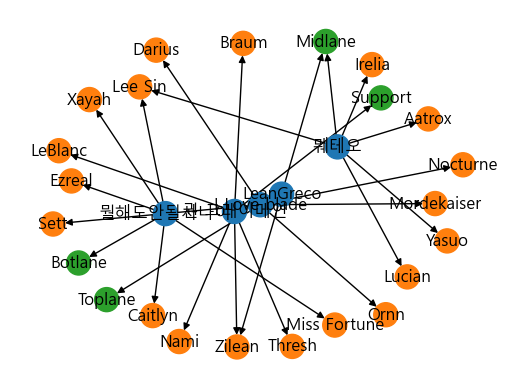

In [6]:
nodes_types = nx.get_node_attributes(g, 'type')
nodes_player = [node for node in nodes_types if nodes_types[node] == "Player"]
nodes_champion = [node for node in nodes_types if nodes_types[node] == "Champion"]
nodes_position = [node for node in nodes_types if nodes_types[node] == "Position"]

subgraph = nx.DiGraph(g.subgraph(nodes_champion + nodes_position + nodes_player[:5]))
subgraph.remove_nodes_from([node for node, degree in dict(subgraph.degree()).items() if degree == 0])
visualize_graph(subgraph)

## Train-/ Test-Splits

In order to generate the train and test set we build a dataframe from the positions of the players. 
Then we create a train and test set with a (90%, 10%) split. 
To avoid data leakage, we remove the test-set edges from the graph. 

In [7]:
edges = nx.to_pandas_edgelist(g)
edges = edges[['source', 'type', 'target']]
edges_position = edges[edges["type"] == "HAS_POSITION"]
edges_champ = edges[edges["type"] == "PLAYS_CHAMP"]
edges_position_train, edges_position_test_validation = train_test_split(edges_position, random_state=random_state, train_size=0.8)
edges_position_test, edges_position_validation = train_test_split(edges_position_test_validation, random_state=random_state, train_size=0.5)

In [8]:
training  = TriplesFactory.from_labeled_triples(triples=pd.concat([edges_champ, edges_position_train]).values)
training 

TriplesFactory(num_entities=9874, num_relations=2, create_inverse_triples=False, num_triples=53834)

In [9]:
validation = TriplesFactory.from_labeled_triples(triples=edges_position_validation.values)
validation 

TriplesFactory(num_entities=978, num_relations=1, create_inverse_triples=False, num_triples=973)

In [10]:
testing = TriplesFactory.from_labeled_triples(triples=edges_position_test.values)
testing 

TriplesFactory(num_entities=977, num_relations=1, create_inverse_triples=False, num_triples=972)

In [123]:
result = pipeline(
    model="transr",
    training=training,
    validation=validation,
    testing=validation,
    random_seed=random_state,
    model_kwargs=dict(embedding_dim=20), #scoring_fct_norm=1
    training_kwargs=dict(num_epochs=50, batch_size=128),
    #optimizer='SGD',
    optimizer_kwargs=dict(lr=0.01),
    #loss='marginranking',
    #loss_kwargs=dict(margin=1),
    #training_loop='slcwa',
    #negative_sampler='basic',
    #negative_sampler_kwargs=dict(num_negs_per_pos=1),
    #evaluator_kwargs=dict(filtered=True),
    #evaluation_kwargs=dict(batch_size=128),
    device="cuda",
    stopper="early",
    stopper_kwargs=dict(frequency=1, relative_delta=0.002),
)

INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: C:\Users\Nico\.data\pykeen\checkpoints\best-model-weights-d7581e3d-53e1-40d2-b31b-34de44d08047.pt


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/421 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/973 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.56s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 1: 0.0010277492291880781. Saved model weights to C:\Users\Nico\.data\pykeen\checkpoints\best-model-weights-d7581e3d-53e1-40d2-b31b-34de44d08047.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 1.


Training batches on cuda:0:   0%|          | 0/421 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/973 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.50s seconds


Training batches on cuda:0:   0%|          | 0/421 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/973 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.49s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 3: 0.009249743062692703. Saved model weights to C:\Users\Nico\.data\pykeen\checkpoints\best-model-weights-d7581e3d-53e1-40d2-b31b-34de44d08047.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 3.


Training batches on cuda:0:   0%|          | 0/421 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/973 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.45s seconds


Training batches on cuda:0:   0%|          | 0/421 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/973 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.50s seconds
INFO:pykeen.stoppers.early_stopping:Stopping early at epoch 5. The best result 0.009249743062692703 occurred at epoch 3.
INFO:pykeen.stoppers.early_stopping:Re-loading weights from best epoch from C:\Users\Nico\.data\pykeen\checkpoints\best-model-weights-d7581e3d-53e1-40d2-b31b-34de44d08047.pt


Evaluating on cuda:0:   0%|          | 0.00/973 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.38s seconds


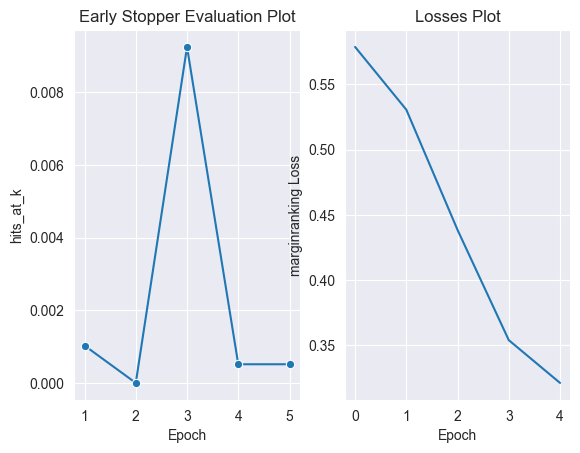

In [124]:
plt.subplot(1, 2, 1)
result.plot_early_stopping()
plt.subplot(1, 2, 2)
result.plot_losses()
plt.show()

In [125]:
def predict(model):
    y, y_hat = [], []
    
    for row in edges_position_train.itertuples():
        source, target = row[1], row[3]
    
        pred = predict_target(model=model, head=source, relation="HAS_POSITION", triples_factory=training)
        pred_df = pred.df.loc[pred.df[pred.df["tail_label"].isin(nodes_position)]["score"].idxmax()]
        
        y.append(target)
        y_hat.append(pred_df["tail_label"])
        
    return y, y_hat

test_targets, test_predictions = predict(result.model)

In [126]:
print(classification_report(test_targets, test_predictions))

                                                precision    recall  f1-score   support

4:abbe0952-2458-485b-a26a-9f3828f2c994:1833121       0.57      0.44      0.50      1133
4:abbe0952-2458-485b-a26a-9f3828f2c994:1833122       0.35      0.23      0.28      1249
4:abbe0952-2458-485b-a26a-9f3828f2c994:1833123       0.68      0.69      0.69      2552
4:abbe0952-2458-485b-a26a-9f3828f2c994:1833124       0.68      0.73      0.70      1386
4:abbe0952-2458-485b-a26a-9f3828f2c994:1833125       0.61      0.84      0.71      1456

                                      accuracy                           0.62      7776
                                     macro avg       0.58      0.59      0.57      7776
                                  weighted avg       0.60      0.62      0.60      7776

